# Práctica 5 : Regresión lineal regularizada: sesgo y varianza
#### Realizado por Javier Gómez Moraleda y Unai Piris Ibañez

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [2]:
# Cargamos el fichero de datos
data = loadmat('ex5data1.mat')

# Datos de entrenamiento (12, 1)
X = data['X']
y = data['y'].ravel()

# Ejemplos de validación (21, 1)
Xval = data['Xval'] 
yval = data['yval'].ravel()

# Ejemplos de prueba (21, 1)
Xtest = data['Xtest']
ytest = data['ytest'].ravel()

## Parte 1 - Regresión lineal regularizada

In [3]:
# Cálculo del coste regularizado
def cost_reg(Thetas, X, y, lam):
    
    # Número de filas
    m = np.shape(X)[0]
    
    # Hipótesis
    H = np.dot(X, Thetas)
    
    # Coste + regularización
    Term1 = (1 / (2*m)) * np.sum(np.square((H - y)))
    Term2 = (lam / (2*m)) * np.sum(np.square(Thetas[1:]))
    
    return Term1 + Term2

In [4]:
# Calcula el gradiente regularizado
def gradient_reg(Thetas, X, y, lam):
    
    # Número de filas
    m = np.shape(X)[0]

    # Hipótesis
    H = np.dot(X, Thetas)
    
    # Gradiente + regularización
    result = (1 / m) * np.matmul(H - y, X)
    result[1:] += (lam / (m)) * np.sum(Thetas[1:])

    return result

In [5]:
# Función para pintar la gráfica
def draw_graph(X, y, Z1, Z2):
    plt.figure()
    plt.xlabel("Change in water level (X)")
    plt.ylabel("Water flowing out of the dam (y)")
    
    # Datos de entrenamiento
    plt.plot(X, y, "x", color="red")
    # Funcion generada
    plt.plot(Z1, np.dot(Z2, result[0]), color="blue")

### Observando resultados
Vamos a probar si realiza el cálculo del coste y el gradiente de forma correcta. para ello vamos a inicializar el parámetro de regularización y el vector de Thetas a 1.

In [6]:
# Inicialización de variables
lam = 1
Thetas = np.ones(np.shape(X)[1] + 1)
X_1 = np.hstack([np.ones([np.shape(X)[0], 1]), X])

In [7]:
# El coste debería salir 303,993
coste = cost_reg(Thetas, X_1, y, lam)
print("Coste para lambda=", lam, "y Thetas=", Thetas, ": ", coste)

Coste para lambda= 1 y Thetas= [1. 1.] :  303.9931922202643


In [8]:
# El gradiente debería salir [−15,303; 598,250]
gradiente = gradient_reg(Thetas, X_1, y, lam)
print("Gradiente para lambda=", lam, "y Thetas=", Thetas, ": ", gradiente)

Gradiente para lambda= 1 y Thetas= [1. 1.] :  [-15.30301567 598.25074417]


### Valor óptimo de Thetas
Vamos a buscar el valor óptimo que minimiza el error sobre los ejemplos de entrenamiento. Vamos a fijar el valor de lambda a 0 porque teneos pocos parámetros.

In [9]:
# Obtenemos resultados óptimos
result = opt.fmin_tnc(func=cost_reg, x0=Thetas, fprime=gradient_reg, args=(X_1, y, 0))

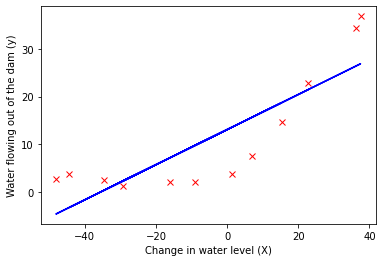

In [10]:
# Pintado de las gráficas
draw_graph(X, y, X, X_1)

## Parte 2 - Curvas de aprendizaje

In [11]:
# Función que devuelve el coste y el gradiente
def cost_and_gradient(Thetas, X, y, lam):
    coste = cost_reg(Thetas, X, y, lam)
    gradiente = gradient_reg(Thetas, X, y, lam)
    return coste, gradiente

In [12]:
# Función que calcula la curva de aprendizaje
def learning_curve(X, y, Xval, yval, lam):
    
    Thetas = np.zeros(np.shape(X)[1])
    
    # Arrays de errores 
    erroresX = np.zeros((X.shape[0],))
    erroresXval = np.zeros((X.shape[0],))
    
    # Cálculo del error para distinta cantidad de datos de entrenamiento
    for i in range(X.shape[0]):
        ejemplaresX = X[0:i+1]
        ejemplaresy = y[0:i+1]
        
        #result = opt.fmin_tnc(func=cost_reg, x0=Thetas, fprime=gradient_reg, args=(ejemplaresX, ejemplaresy, lam))[0]
        result = opt.minimize(fun=cost_and_gradient, x0=Thetas, 
                              args=(ejemplaresX, ejemplaresy, lam), 
                              method='TNC', jac=True, options ={'maxiter': 2000})['x']
        
        erroresX[i] = cost_reg(result, ejemplaresX, ejemplaresy, 0)
        erroresXval[i] = cost_reg(result, Xval, yval, 0)
    
    return erroresX, erroresXval

In [13]:
# Función que dibuja la curva de aprendizaje
def draw_curve_graph(X, erroresX, erroresXval):
    ejeX = range(1, X.shape[0]+1)
    plt.figure()
    plt.plot(ejeX, erroresX, 'b', label = "Entrenamiento")
    plt.plot(ejeX, erroresXval, 'orange', label = "Validacion")
    plt.xlabel("Cantidad de ejemplos de entrenamiento")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

### Observando resultados

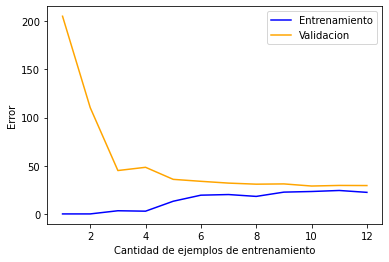

In [14]:
# Se añade una columna de 1's sobre los ejemplos de validación
Xval_1 = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])

# Cálculo de errores
erroresX, erroresXval = learning_curve(X_1, y, Xval_1, yval, 0)

# Pintado de gráficas
draw_curve_graph(X, erroresX, erroresXval)

## Parte 3 - Regresion polinomial

In [15]:
# Genera el polinomio
def make_data(X, grado):
    poly = PolynomialFeatures(grado)
    X = poly.fit_transform(X)
    return X

In [16]:
# Normalización con StandardScaler
def normalizar(X):
    Scaler = StandardScaler()
    X = Scaler.fit_transform(X)
    mu = Scaler.mean_
    sigma = Scaler.scale_
    return X, mu, sigma

### Observando resultados

In [17]:
# Inicialización de los datos
X_poly = make_data(X, 8)
X_poly[:, 1:], mu, sigma = normalizar(X_poly[:, 1:])
Thetas = np.ones(X_poly.shape[1])

# Regresión lineal
result = opt.fmin_tnc(func=cost_reg, x0=Thetas, fprime=gradient_reg, args=(X_poly, y, 0))

In [18]:
# Predicciones sobre nuevos valores de x
X_evaluate = np.arange(X.min() - 4, X.max() + 4, 0.05)
X_evaluate = X_evaluate.reshape(-1, 1)
X_evaluate_poly = make_data(X_evaluate, 8)
X_evaluate_poly[:, 1:] = (X_evaluate_poly[:, 1:] - mu)/sigma

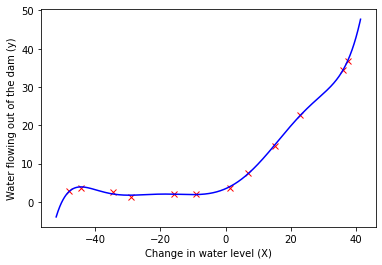

In [19]:
# Pintado de las gráficas
draw_graph(X, y, X_evaluate, X_evaluate_poly)

### Curvas de aprendizaje

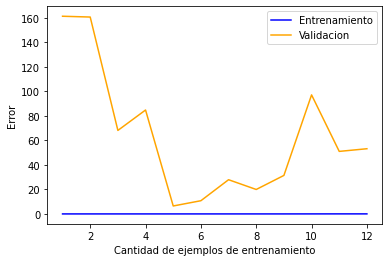

[5.96106818e-18 1.14620240e-19 1.07744381e-16 3.22799595e-15
 6.89387518e-14 5.73573826e-10 1.63633101e-07 1.30538303e-06
 1.96423821e-04 1.08255825e-02 3.12190211e-02 2.88973745e-02]
[161.44216832 160.79229163  68.19093719  84.8573197    6.48695001
  10.78172189  27.93292859  19.96180778  31.43865638  97.21083965
  51.06413962  53.23495718]


In [20]:
lam = 0

Xval_poly = make_data(Xval, 8)
Xval_poly[:, 1:] = (Xval_poly[:, 1:] - mu)/sigma

# Cálculo de errores
erroresX, erroresXval = learning_curve(X_poly, y, Xval_poly, yval, lam)

# Pintado de gráficas
draw_curve_graph(X, erroresX, erroresXval)

print(erroresX)
print(erroresXval)

## parte 4 seleccion del parametro λ